## OddsJam +EV Data Science Assignment

### Background

Heading into this assignment, I was limited on sports betting knowledge in areas such as markets, how odds work, types of trades, etc but have experience watching and analyzing most sports which helped throughout developing a base understanding of these markets. As with anything, the learning curve is toughest at first, but momentum eventually takes hold and you begin to compound your knowledge. Sports betting is no different and I felt more comfortable after each time I researched the space. It would be great to get any feedback on my logic through some of the trades I suggested. I am trying to learn as much as possible about the space and welcome all feedback no matter how critical.

#### What is +EV sports betting?
To begin, without considering sports betting, +EV is the idea that with any given investment or trade the potential gains from this trade outweigh the potential losses, and in the long run you can expect to make a profit. 

Mathamatically speaking for a single event, EV = (Probablity of Winning * PNL) - (Probablity of Losing * PNL). We find the probablity used in this calculation by using the equation Implied Probablity = 1 / (Decimal Odds + 1). 

#### Example: Since I am a huge F1/Lewis  fan...

Lewis currently has odds of +2800 to win the Driver's Championship this year, so if I place a $100 bet on him my payoff would be $2,800 in the event of him winning. I have a strong positive view about the change-of-concept Mercedes is pushing with their car this year, so I personally place Lewis' odds to be at 30% to win the championship. 

EV = (0.30 * $2,700) - (0.70 * $100) = $530 -> In this case, I would consider taking this bet as the payoff in the event of a win outweighs that of a loss.

For +EV betting, instead of making up these odds, on we price bets off an implied probablity that is closer to fair market. This is discussed below. 

#### Assumptions around Probablity
To effectively place these bets, we need to have a good idea of where the fair odds of a bet are. Odds are not always the same across all sportsbooks, so which should we be pricing our bets off? Using a two-sided betting exchange like BetFair would be useful, as we can use mid-market as 'fair' value. Looking at sportsbooks, Pinnacle (who set the most lines in our dataset) is the sharpest book on the market as it usually has the highest liquidity in most markets. 

#### Market Dynamics
Once a +EV bet it placed, it may not remain a +EV bet forever. This is because other traders have the ability to swing the lines on a trade by taking large positions on the other side of the market (execution = some level of information), so the bookmaker is forced to shift the line. So, knowing how liquid your the market you're trading is important as markets with low-liquidity are easier to swing than highly liquid markets. This will not be touched on in this project but it is one of the more interesting parts of Sports Trading to me. 

### Hypothesis

There are a few things I would like to explore around +EV betting, and while I will not be able to dive into all of them during this assignment, I listed them below and hope to work through some of these problems in the future.

**Injury / Ejection Live Betting**: Of the +EV strategies that I have been scheming through, I believe that this the most interesting of the oppurtunites I would like to explore. Though this would not be high volume strategy, I imagine the quality of bets that you would be able to place would be significantly better than vanilla +EV strategies. I am also making some assumptions around how possible this strategy is since I have not traded any sports markets before, but this would be impossible for the average sports better due to the technical/latency requirements. Additionally, I am not sure how popular this strategy currently is, if there are many sharp traders in this market already it may not be worth exploring.

**Derivatives Betting**: Heading into this assignment, this is the strategy that I hypothesized would yield the most +EV oppurtunities. These bets are derived from the full-game odds and could be explotiable in the event of large swings to full-game odds. Additionally, there may be patterns in teams rotations (such as resting starters in a certain quarter in NBA) to capitzalize on, and the derivatives market allows you to place focused bets on these odds.

**Specalized Handicap Models**: I also believe that there is major room for improvement by focusing on certain niche sports and building out handicap models that are influenced by experts in this specific market. Personally, I can do this for Formula 1 (seems to be very niche among traders as well), but obviously see the oppurtunity for the major sports as well. Instead of copying the odds from Pinnacle or another sharp book, it would be ideal if OddsJam targeted making lines for niche / not-well-covered sports and started supplying these as well.

In [214]:
import os
import json
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['green'])

In [2]:
## Functions...
def get_data():

    tool = flatten_data('betting_tool.json')
    odds = pd.read_json("odds.json")
    
    tool['start_date'] = tool['start_date'].apply(lambda x: timestamp_to_unix(x))
    tool = drop_non_ev_bets(tool)
    
    data = odds.copy().T
    data['start_date'] = pd.to_numeric(data['start_date'])

    return tool, data

def get_data_multiple_files(path):
    df = pd.DataFrame()
    for file in os.listdir(path):
        if file.startswith('.'):
            continue
        print(f'processing file {file}')
        with open(os.path.join(path, file), 'r') as f:
            df1 = pd.read_json(f)
            df = pd.concat([df, df1])
    return df

def get_tool_data_multiple_files(path):
    df = pd.DataFrame()
    for file in os.listdir(path):
        if file.startswith('.'):
            continue
        print(f'processing file {file}')
        df1 = flatten_data(f'{path}/{file}')
        df = pd.concat([df, df1])
    return df

def drop_non_ev_bets(df):
    return df[df['type'] == 'edge']

def timestamp_to_unix(timestamp_str):
    dt = datetime.datetime.fromisoformat(timestamp_str)
    return int(dt.timestamp())

def merge_data(df1, df2, limit):
    return pd.merge(df1[:limit], df2[:limit], on='start_date')  
    

def flatten_data(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    dfs = []

    for obj in data:
        df = pd.json_normalize(data[obj]['data'])
        
        meta = [{'game_id': data[obj]['game_id'], 
                 'type': data[obj]['type'], 
                 'normalized_market': data[obj]['normalized_market'], 
                 'is_live': data[obj]['is_live']}]*len(df)
        for i, m in enumerate(meta):
            for k, v in m.items():
                df.loc[i, k] = v
        
        dfs.append(df)

    result = pd.concat(dfs, ignore_index=True)

    result = result.dropna(axis=1, how='all')

    return result

def implied_probability(odds: float) -> float:
    if odds > 0:
        return 100 / (odds + 1) * 100
    else:
        return abs(odds) / (abs(odds) + 100) * 100

def payout(odds: float) -> float:
    wager = 100
    if odds > 0:
        return (odds / 100 * wager)
    else:
        return 100 / abs(odds) * wager

def calculate_implied_probabilities(df: pd.DataFrame) -> pd.DataFrame:
    df['home_implied_probability'] = df['best_price_home_odd'].apply(implied_probability)
    df['away_implied_probability'] = df['best_price_away_odd'].apply(implied_probability)
    return df

def calculate_payout(df: pd.DataFrame) -> pd.DataFrame:
    df['home_profit'] = df['best_price_home_odd'].apply(payout)
    df['away_profit'] = df['best_price_away_odd'].apply(payout)
    return df
    

### Get the Data

Odds Data: 26 x 354,024
Tool Data: 158,907 x 44

In [3]:
odds_data = get_data_multiple_files('/Users/admin/Downloads/drive-download-20230416T001727Z-001')
odds_data = odds_data.head(26)

processing file 2023-01-26T11_15_06Z.json
processing file 2023-01-26T10_46_31Z.json
processing file 2023-01-26T10_00_06Z.json
processing file 2023-01-26T11_30_06Z.json
processing file 2023-01-26T11_01_37Z.json
processing file 2023-01-26T12_00_07Z.json
processing file 2023-01-26T10_15_06Z.json
processing file 2023-01-26T11_45_05Z.json
processing file 2023-01-26T10_30_05Z.json


In [30]:
tool_data = get_tool_data_multiple_files('/Users/admin/Downloads/tool-data')

processing file 2023-01-26T11_15_04Z.json
processing file 2023-01-26T11_01_34Z(1).json
processing file 2023-01-26T10_00_04Z.json
processing file 2023-01-26T10_46_28Z.json
processing file 2023-01-26T11_01_34Z.json
processing file 2023-01-26T10_46_28Z(1).json
processing file 2023-01-26T10_00_04Z(1).json
processing file 2023-01-26T11_30_04Z.json
processing file 2023-01-26T10_15_04Z(1).json
processing file 2023-01-26T11_15_04Z(1).json
processing file 2023-01-26T10_30_04Z(1).json
processing file 2023-01-26T10_15_04Z.json
processing file 2023-01-26T11_30_04Z(1).json
processing file 2023-01-26T10_30_04Z.json
processing file 2023-01-26T11_45_04Z.json


### Understanding the Features - Odds Dataset

As with any Data Science project, we must first understand what we are trying to explore before diving straight in. Below, I included personal definitions of each of these features. 

* **odd_id**: unique to each set of odds
* **feed_id**: not entirely sure, but guessing I would assume would be attributable to the source of the bet (ie. William Hill, PointsBet, etc.)
* **sport**: self-explanatory
* **league**: ^
* **sportsbook**: ^
* **bet_name**: this is the name full name of the bet including the name of the player/team involved.
* **bet_type**: the type of the bet - this could be any type of prop bet, moneyline, spread, etc - there are a few types in here that I am not familiar with and will require research
* **bet_points**: RESEARCH
* **player_id**: for player specific bets only, otherwise is null
* **start_date**: unix for startdate
* **checked_date**: unix for checked_date
* **normalized_***: normalzied titles for sportsbook, bet_type, bet_name, sport, and league
* **game_id**: id for the game/match for the odds

### Understanding the Betting Tool & Positive EV Bets

### Columns from https://oddsjam.com/betting-education/how-to-use-the-oddsjam-positive-ev-tool

* **percent**: EV % / expected profit margin for the bet
* **market_width**: the vig being charged by the sportsbook
* **book specific odds**: This is interesting, currently it seems the tool uses a weighted method to get the bet price, but I would like to try a wisdom-of-the-crowds method to see if this yields better 'true odds'. This method would be better if we used data from all available sports books as opposed to the few in this dataset, but it is still worth exploring. Since OddsJam has so much data from Sportsbooks across the US, I think this makes sense to try. As mentioned previously, I imagine that we will not be able to generlize our findings across sports, rather our edge will come from the unique scenarios we uncover in certain markets/sports. I expect this to be true in this case as well.
* **weighted_price_***: Mentioned above; I am not sure how this is currently being calculated, but I imagine we could adjust the weights for this to be based on sports/market to improve our true odds.


In [149]:
stub = [
    'bol_price_home_odd', 'bol_price_away_odd', 'dk_price_home_odd', 
    'dk_price_away_odd', 'fd_price_home_odd', 'fd_price_away_odd', 
    'czr_price_home_odd', 'czr_price_away_odd', 'br_price_home_odd', 
    'br_price_away_odd', 'bovada_price_home_odd', 'bovada_price_away_odd', 
    'wynn_price_home_odd','wynn_price_away_odd', 'betus_price_home_odd', 'betus_price_away_odd'
]

### Exploration

In [6]:
tool_edge = tool_data[tool_data['type'] == 'edge'].copy()

#### Breaking Down The Markets

As expected, the most common bets show up most frequently in our tool dataset, but there is also a healthy amount of derivative/prop bets. Interestingly, the most popular derivative bets suggested by the betting tool originate at the beginning of a game (1st Quarter, 1st Half, etc). This being said, I wonder if there is a way to optimize oour strategy around deriv bets in the backhalf of games. 

<Axes: ylabel='market'>

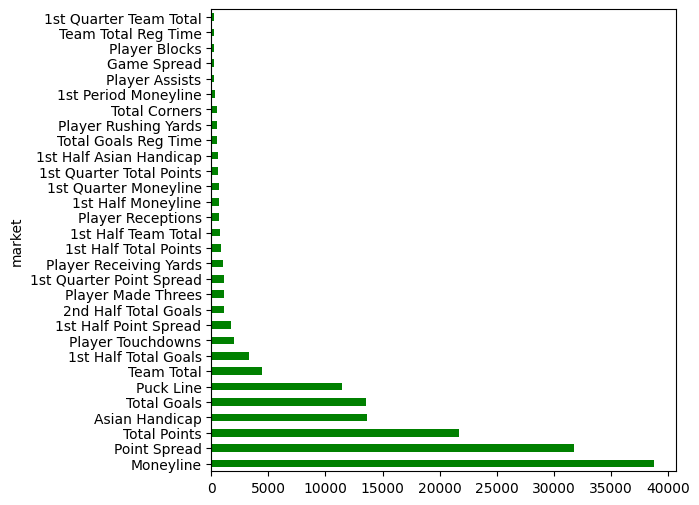

In [119]:
plt.figure(figsize=(6,6))
tool_data['market'].value_counts()[:30].plot.barh()

#### Pre-Match vs. Live Bets

I was also surpirsed by the disproportion of pre-match bets to live bets suggested by the tool. Though pre-match bet markets are much more stable than live bets and more information is available, there has to be oppurtunity to find +EV in the live betting market. As mentioned previously, a strategy around injuries is very interesting (though very challenging technically). Another option for live betting could be found in momentumn swings.

([<matplotlib.patches.Wedge at 0x3e119dfd0>,
 [Text(-1.0999864539764972, 0.005459035465295678, 'Pre-Match Bet'),
  Text(1.0999864537548816, -0.0054590801203198884, 'Live Bet')],
 [Text(-0.5999926112599075, 0.0029776557083430965, '99.8%'),
  Text(0.5999926111390262, -0.0029776800656290295, '0.2%')])

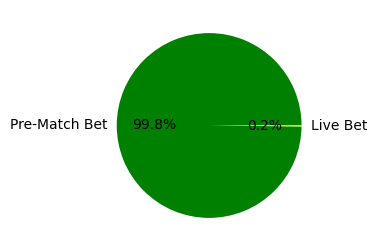

In [122]:
sizes = [tool_data[tool_data['is_live'] == False].size, tool_data[tool_data['is_live'] == True].size]
labels = ['Pre-Match Bet', 'Live Bet']
plt.figure(figsize=(3, 3))
plt.pie(x=sizes, labels=labels, colors=('green', 'yellow'), autopct='%1.1f%%')

#### Correlated Books

In theory, all sportsbooks should be perfectly correlated, as they all should be acting on the same information and that's how we achive price discovery. In practice, there are instances in which odds between books are dislocated due to risk/strategy, liquidity, timing, other traders, etc. As we see below looking at the edges data, overall this is the case.

<Axes: >

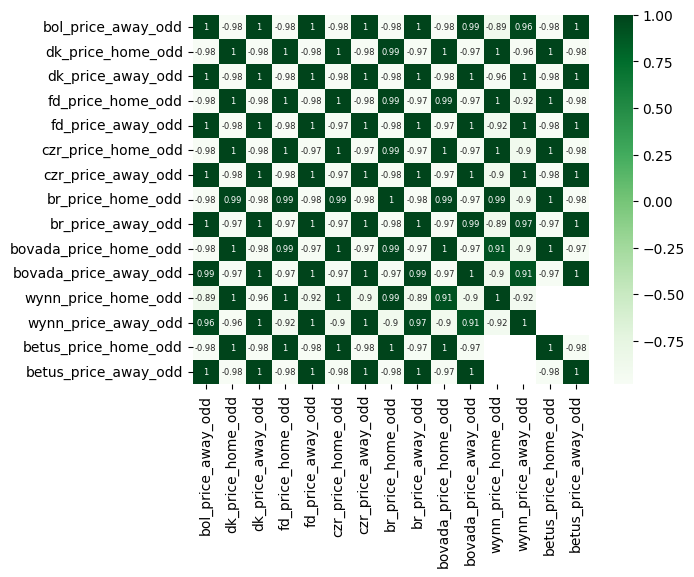

In [9]:
corr = tool_edge[stub].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap='Greens', annot=True, annot_kws={"size":6})

#### Sportsbooks and MIPR

During research, I came across MIPR after seeing if there was some sort of Imp Vol equivalent in sports trading.

To begin, MIPR is the Market Implied Probability Range.  It is calculated by taking the difference between the highest implied probability of the outcome offered by one sportsbook and the lowest implied probability of the opposite outcome offered by another sportsbook, and then taking the average of these two ranges. 

First, it would show us how much disagreement there is among books in pricing. The higher the MIPR the more disagreement among books and more oppurtunity for finding +EV. This allows us to find oppurtunites for value bets and asses market confidence. Also, we could use MIPR to monitor market movements and uncover changes in sentiment. If we see MIPR increase significantly in a short amount of time we can infer that a trader took a large position on those odds or a one-off event happeed (injury/player out, weather changes, upsets in tournaments, etc).

**Note:** Though this assignment was only supposed to focus on edges, significant MIPR was only found in Point Spreads. 

 All other optimization strategies will be +EV focused. After more research after implementing this, I found that MIPR is commonly used for finding Arb Ops, not as much for finding edge.

In [282]:
stub_w_mipr = [
    'market', 'home_team', 'away_team',
    'best_price_home_name', 'best_price_away_name',
    'best_price_home_odd', 'home_woc',
    'best_price_away_odd', 'away_woc',
    'home_ev', 'away_ev',
    'best_price_home_odd_books', 'best_price_away_odd_books',
    'mipr'
]

stub_w_best_price = [
    'best_price_home_odd', 'oddsjam_price_home_odd',
    'best_price_away_odd','oddsjam_price_away_odd',
    'home_edge_percent', 'away_edge_percent',
    *stub,
]

home_odds_stub = [
    'bol_price_home_odd', 'dk_price_home_odd',
    'fd_price_home_odd', 'czr_price_home_odd',
    'br_price_home_odd', 'bovada_price_home_odd',
    'wynn_price_home_odd', 'betus_price_home_odd'
]

away_odds_stub = [
    'bol_price_away_odd', 'dk_price_away_odd',
    'fd_price_away_odd', 'czr_price_away_odd',
    'br_price_away_odd', 'bovada_price_away_odd',
    'wynn_price_away_odd', 'betus_price_away_odd'
]

In [252]:
def calculate_mipr(row):
    home_odds = row[home_odds_stub]
    away_odds = row[away_odds_stub]
    
    home_decimal_odds = np.where(home_odds > 0, (100 / home_odds) + 1, (1 - (home_odds / -100)))
    away_decimal_odds = np.where(away_odds > 0, (100 / away_odds) + 1, (1 - (away_odds / -100)))
    
    home_prob = 1 / home_decimal_odds
    away_prob = 1 / away_decimal_odds
    
    home_win_range = np.max(home_prob) - np.min(away_prob)
    away_win_range = np.max(away_prob) - np.min(home_prob)
    
    mipr = np.mean([home_win_range, away_win_range])
    
    return mipr

def calculate_home_ev(row):
    wager = 100
    
    theo = row['home_woc']
    market = row['best_price_home_odd']
    
    home_decimal_odds = np.where(theo > 0, (theo / 100) + 1, (1 - (100 / theo)))
    home_win_payout = np.where(theo > 0, (market / 100 * wager), (100 / abs(market) * wager))
    
    home_prob = 1 / home_decimal_odds
    complement = 1 - home_prob
    
    loss_payout = wager
    
    win_leg = (home_prob * home_win_payout)
    loss_leg = (complement * loss_payout)
    
    ev =  win_leg - loss_leg
    
    return round(ev, 2)

def calculate_away_ev(row):
    wager = 100
    
    theo = row['away_woc']
    market = row['best_price_away_odd']
    
    away_decimal_odds = np.where(theo > 0, (theo / 100) + 1, (1 - (100 / theo)))
    away_win_payout = np.where(theo > 0, (market / 100 * wager), (100 / abs(market) * wager))
    
    away_prob = 1 / away_decimal_odds
    complement = 1 - away_prob
    
    loss_payout = wager
    
    win_leg = (away_prob * away_win_payout)
    loss_leg = (complement * loss_payout)
    
    ev =  win_leg - loss_leg
    
    return round(ev, 2)

def structure_bet(df):
    wager = 100
    
    home_ev = df['home_win_ev']
    away_ev = df['away_win_ev']
    
    def objective(x):
        payout = -(home_ev*x[0] + away_ev*x[1]).sum()
        return payout
    
    cons = ({'type': 'ineq', 'fun': lambda x:  x[0] + x[1] - wager})
    x0 = np.array([wager/2, wager/2])
    res = minimize(objective, x0, method='SLSQP', constraints=cons)
    
    df['wager_home'] = res.x[0]
    df['wager_away'] = res.x[1]
    
    total_payout = df['home_win_ev']*df['wager_home'] + df['away_win_ev']*df['wager_away']
    df['profit'] = total_payout - wager
    
    return df
    

def calculate_wisdom_of_crowd(df):
    df['home_woc'] = df[home_odds_stub].mean(axis=1)
    df['away_woc'] = df[away_odds_stub].mean(axis=1)
    df = df.drop(index=df[df['home_woc'] == 0].index)
    df = df.drop(index=df[df['away_woc'] == 0].index)
    return df

def plot_odds(df, odd_id):
    plt.figure(figsize=(15, 4))
    home_title = df.T[odd_id].loc['best_price_home_name']
    away_title = df.T[odd_id].loc['best_price_away_name']
    
    plt.subplot(1, 2, 1)
    plt.title(f'Home Odds Pricing - {home_title}')
    df[home_odds_stub].T[odd_id].plot.barh()
    ax = plt.gca()
    ax.invert_xaxis()
    
    plt.subplot(1, 2, 2)
    plt.title(f'Away Odds Pricing - {away_title}')
    df[away_odds_stub].T[odd_id].plot.barh()
    ax = plt.gca()
    ax.invert_xaxis()
    
    plt.tight_layout()
    
def plot_sport_and_market(df):
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.title('Count By Sport')
    tool_edge['sport'].value_counts().plot.barh()
    
    plt.subplot(1, 2, 2)
    plt.title('Count By Market')
    tool_edge['market'].value_counts().plot.barh()
    plt.tight_layout()
    
def plot_odds_corr_heatmaps(df):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
    
    home_corr = df[home_odds_stub].corr()
    sns.heatmap(home_corr, cmap='Greens', annot=True, annot_kws={"size":8}, ax=axes[0])
    axes[0].set_title('High MIPR Home Odds Corr')
    
    away_corr = df[away_odds_stub].corr()
    sns.heatmap(away_corr, cmap='Greens', annot=True, annot_kws={"size":8}, ax=axes[1])
    axes[1].set_title('High MIPR Away Odds Corr')
    
    plt.tight_layout()
    
def plot_bet_price_over_time(game_id, market):
    df = tool_edge[(tool_edge['game_id'] == game_id) & (tool_edge['normalized_market'] == market)].reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df.index, df['best_price_home_odd'], color='green', linewidth=2, linestyle='-', marker='o', label='Best Home Odds')
    ax.plot(df.index, df['best_price_away_odd'], color='orange', linewidth=2, linestyle='-', marker='o', label='Best Away Odds')
    
    ax.set_ylabel('Best Odds')
    ax.set_title('Best Odds for NY vs BOS')
    ax.grid(True)
    ax.set_xlim(df.index.min(), df.index.max())
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.legend()

In [32]:
tool_data['mipr'] = tool_data.apply(calculate_mipr, axis=1)

In [34]:
tool_data = calculate_wisdom_of_crowd(tool_data)
tool_data['home_ev'] = tool_data.apply(calculate_home_ev, axis=1)
tool_data['away_ev'] = tool_data.apply(calculate_away_ev, axis=1)

In [35]:
mipr = tool_data[tool_data['mipr'] > 0].drop_duplicates(subset='game_id')
mipr = calculate_wisdom_of_crowd(mipr)

##### MIPR / Consensus Theo Results

Using the Wisdom of The Crowd strategy I mentioned earlier, I calculated the average/collective opinion of all available books assuming that the collective opinion of a large group is more accurate than any one individual. Again, this calculation would be more accurate with more Sportsbooks odds, but this will do for now. By only selecting bets high MIPR and using consensus odds as our theoretical odds, I found that most of the bets I was analyzing from the Betting Tools dataset had +EV on both side, which is not a good thing. Though there may be instances where +EV on both sides is common it should not be that way on most of our data. Additionally, some of the odds quoeted below would have us trading against Pinnacle Sportsbook who is known to set the sharpest lines among books.

After this inital research, I could determine that our current WOC calculation is producing weak theoretical lines, so we shouldn't be trading off of these. Instead, we could try to optimize this WOC calculation by gathering data from more sports books or adjusting the method we are averaging by. I am only using a vanilla mean calculation right now, so we can infer a weighted approach is likely the better route. Next, I would like to try to optimize this by looking at this by identifying sharp odds on a sport-by-sport basis.

In [55]:
mipr[stub_w_mipr].T

,561,573,1145,1554,1595,985,1774,2069,2283,2438,762,1051,1061,2648
market,Point Spread,Point Spread,Point Spread,Total Points,Total Points,Total Points,Point Spread,Point Spread,Point Spread,Point Spread,Point Spread,Total Points,Total Points,Total Points
home_team,Northern Kentucky,Tarleton State,Washington State,Towson,Louisiana,Houston Rockets,Oregon,USC,Abilene Christian,Appalachian State,Phoenix Suns,UAB,William & Mary,Boston Celtics
away_team,Green Bay,Utah Tech,Arizona,Northeastern,Troy,Cleveland Cavaliers,Colorado,UCLA,Grand Canyon,Georgia State,Dallas Mavericks,Louisiana Tech,Stony Brook,New York Knicks
best_price_home_name,Green Bay +17.5,Utah Tech +4,Washington State +5.5,Over 129.5,Over 143.5,Over 222.5,Colorado +6.5,USC +5,Abilene Christian +3.5,Georgia State +7,Dallas Mavericks +1.5,Over 150.5,Over 134,Over 226.5
best_price_away_name,Northern Kentucky -17.5,Tarleton State -4,Arizona -5.5,Under 129.5,Under 143.5,Under 222.5,Oregon -6.5,UCLA -5,Grand Canyon -3.5,Appalachian State -7,Phoenix Suns -1.5,Under 150.5,Under 134,Under 226.5
best_price_home_odd,-105.0,-103.0,-105.0,105.0,100.0,-102.0,100.0,-108.0,-102.0,-103.0,-108.0,-104.0,-108.0,102.0
home_woc,-112.8,-110.714286,-110.0,-110.0,-111.166667,-111.333333,-109.25,-112.5,-108.4,-109.714286,-110.0,-108.5,-111.25,-110.285714
best_price_away_odd,-102.0,-103.0,104.0,-105.0,-106.0,-103.0,-107.0,101.0,-105.0,-105.0,101.0,-104.0,103.0,-109.0
away_woc,-107.2,-109.714286,-110.0,-110.285714,-109.333333,-108.833333,-111.0,-107.5,-111.6,-110.714286,-110.125,-111.666667,-108.75,-111.285714
home_ev,3.49,3.55,2.27,2.27,5.29,4.33,4.42,1.96,3.01,3.11,0.88,2.08,1.42,3.86


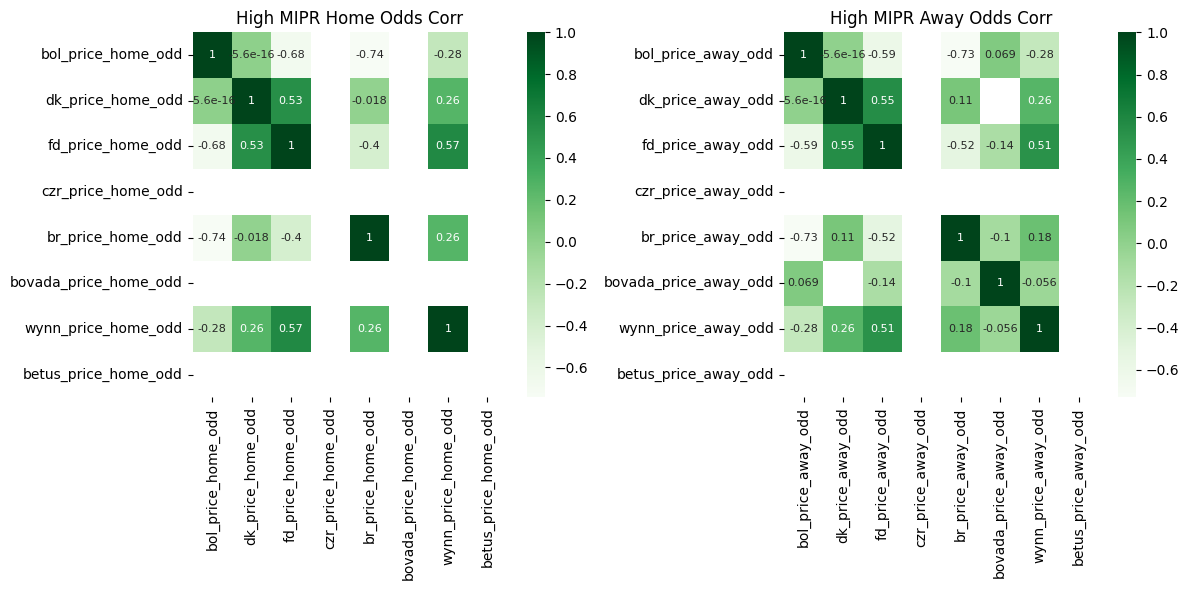

In [170]:
plot_odds_corr_heatmaps(mipr)

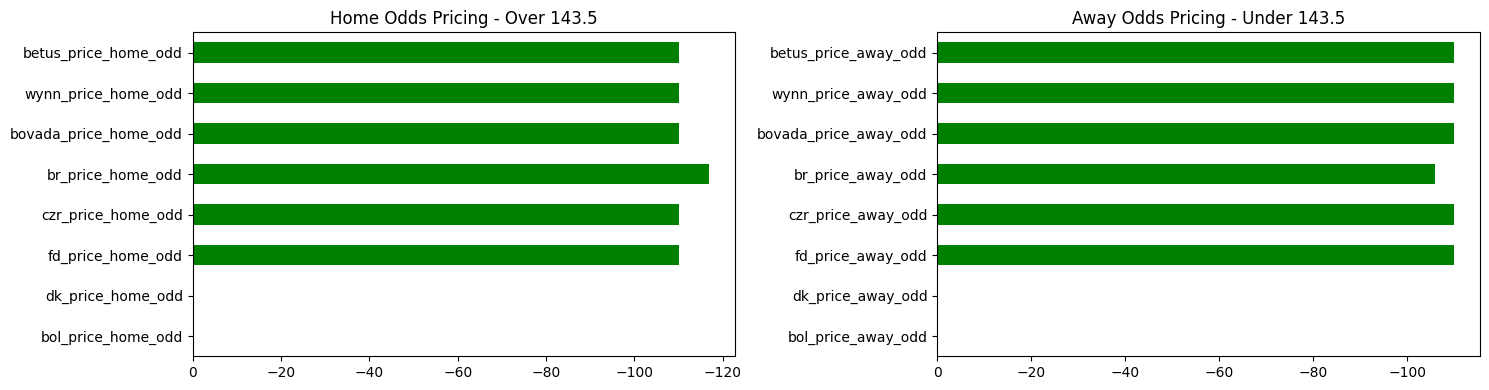

In [123]:
plot_odds(mipr, 1595)

##### Shapest Sportsbook by Sport

Though our data for +EV/edge bets is relatively small, since our data is from late March where mostly basketball games are being played, we still may able to find trends among sportsbooks between sports and possibly inter-sport (league, team, etc.) or market (Moneyline, Point Spread, etc) levels. Since there is mostly Basketball data in this set, I decided to only work exclusively with this sport. 

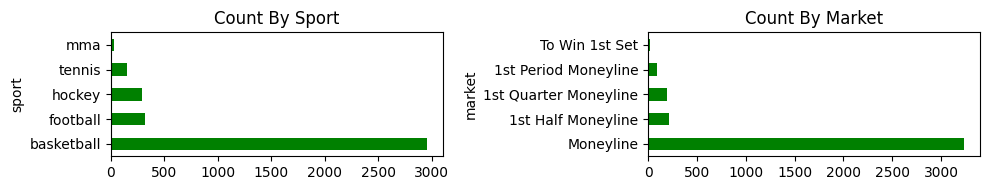

In [191]:
plot_sport_and_market(tool_edge)

##### How Odds Develop Over Time - NYK vs. BOS 1/26

Below we can see the 1st Half Moneyline market for the Knicks / Celtics game this past January. Initally, books priced this bet heavily in favor of the Celtics. The best odds a trader could get when markets started trading here was taking the Knicks ML @ 230 / 30.3% while OddsJam was pricing the likelihood of this event at 213 / 31.95%. Eventually, closer to the event, the books pricing this event actually flipped their position (perhaps took too much risk on the other side) to favoring the Knicks. This turned an initally +EV bet to -EV simply because the odds moved against us. This is also important to consider when placing EV/edge bets.

In [283]:
tool_edge[(tool_edge['game_id'] == '77646-40294-2023-01-26') & (tool_edge['normalized_market'] == '1st_half_moneyline')].reset_index(drop=True)[stub_w_best_price].T

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
best_price_home_odd,-238.0,-250.0,-256.0,-260.0,-263.0,-265.0,-270.0,-275.0,-276.0,-278.0,...,230.0,230.00,230.00,230.00,230.00,230.00,230.00,230.00,230.00,230.00
oddsjam_price_home_odd,-250.0,-250.0,-250.0,-250.0,-250.0,-250.0,-250.0,-250.0,-250.0,-250.0,...,213.0,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00,213.00
best_price_away_odd,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,230.0,...,-278.0,-238.00,-250.00,-255.00,-256.00,-260.00,-263.00,-270.00,-275.00,-278.00
oddsjam_price_away_odd,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,...,-250.0,-250.00,-250.00,-250.00,-250.00,-250.00,-250.00,-250.00,-250.00,-250.00
home_edge_percent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.2,2.39,2.39,2.39,2.39,2.39,2.39,2.39,2.39,2.39
away_edge_percent,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bol_price_home_odd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bol_price_away_odd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dk_price_home_odd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dk_price_away_odd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


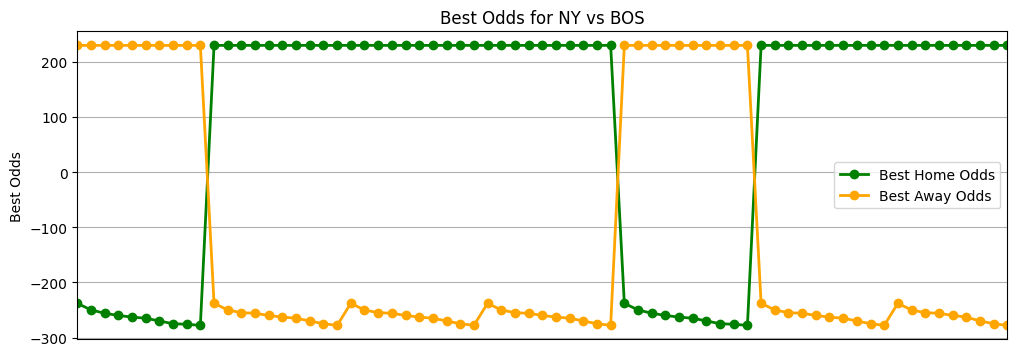

In [251]:
plot_bet_price_over_time(game_id='77646-40294-2023-01-26', market='1st_half_moneyline')

#### Odds Data & Selecting +EV Bets

In [ ]:
odds_data_T = odds_data.copy().T

In [290]:
feed_stub = [
    'feed_id', 'sportsbook'
]

<Axes: ylabel='sportsbook'>

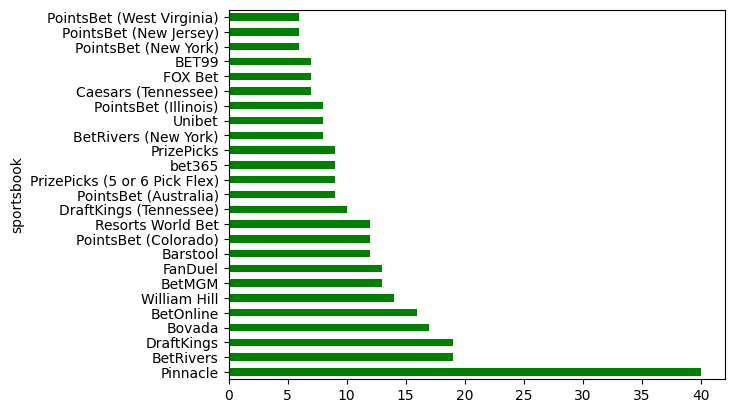

In [299]:
odds_data_T[feed_stub].drop_duplicates()['sportsbook'].value_counts()[:25].plot.barh()

In [288]:
odds_data_T[odds_data_T['game_id'] == '26994-38911-2023-02-04']

,odd_id,feed_id,sport,league,sportsbook,bet_name,bet_type,bet_price,bet_points,player_id,...,home_rotation_number,start_date,checked_date,normalized_sportsbook,normalized_bet_type,normalized_bet_name,normalized_sport,normalized_league,game_id,home_team
odd:26994-38911-2023-02-04:betfair_exchange:asian_handicap:brighton_hove_albion_+0_5,D17E5E4C1D22,5533,soccer,England - Premier League,Betfair Exchange,Brighton & Hove Albion +0.5,Asian Handicap,-1053.0,0.5,,...,,1675522800,1674627891,betfair_exchange,asian_handicap,brighton_hove_albion_+0_5,soccer,england_-_premier_league,26994-38911-2023-02-04,Brighton & Hove Albion
odd:26994-38911-2023-02-04:barstool:first_goalscorer:chris_mepham,22C40A6795E2,5149,soccer,England - Premier League,Barstool,Chris Mepham,First Goalscorer,20000.0,,,...,,1675522800,1674723461,barstool,first_goalscorer,chris_mepham,soccer,england_-_premier_league,26994-38911-2023-02-04,Brighton & Hove Albion
odd:26994-38911-2023-02-04:unibet:total_goals:over_4_25,6E9EA1982586,5195,soccer,England - Premier League,Unibet,Over 4.25,Total Goals,360.0,4.25,,...,,1675522800,1674707717,unibet,total_goals,over_4_25,soccer,england_-_premier_league,26994-38911-2023-02-04,Brighton & Hove Albion
odd:26994-38911-2023-02-04:unibet:first_goalscorer:dominic_solanke,3055ED667077,5195,soccer,England - Premier League,Unibet,Dominic Solanke,First Goalscorer,1200.0,,,...,,1675522800,1674707717,unibet,first_goalscorer,dominic_solanke,soccer,england_-_premier_league,26994-38911-2023-02-04,Brighton & Hove Albion
odd:26994-38911-2023-02-04:bet99:1st_half_asian_handicap:brighton_hove_albion_-0_5,CB451AE3B52B,5315,soccer,England - Premier League,BET99,Brighton & Hove Albion -0.5,1st Half Asian Handicap,-125.0,-0.5,,...,,1675522800,1674334467,bet99,1st_half_asian_handicap,brighton_hove_albion_-0_5,soccer,england_-_premier_league,26994-38911-2023-02-04,Brighton & Hove Albion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
odd:26994-38911-2023-02-04:draftkings:2nd_half_both_teams_to_score:no,B319C1229EF5,5054,soccer,England - Premier League,DraftKings,No,2nd Half Both Teams To Score,-425.0,,,...,,1675522800,1674334626,draftkings,2nd_half_both_teams_to_score,no,soccer,england_-_premier_league,26994-38911-2023-02-04,Bournemouth
odd:26994-38911-2023-02-04:unibet:asian_handicap:brighton_hove_albion_-2_75,B6137C242F85,5195,soccer,England - Premier League,Unibet,Brighton & Hove Albion -2.75,Asian Handicap,290.0,-2.75,,...,,1675522800,1674707717,unibet,asian_handicap,brighton_hove_albion_-2_75,soccer,england_-_premier_league,26994-38911-2023-02-04,Brighton & Hove Albion
odd:26994-38911-2023-02-04:betfair_exchange:asian_handicap:bournemouth_+0,48495C74E6F4,5533,soccer,England - Premier League,Betfair Exchange,Bournemouth +0,Asian Handicap,685.0,0,,...,,1675522800,1674730498,betfair_exchange,asian_handicap,bournemouth_+0,soccer,england_-_premier_league,26994-38911-2023-02-04,Brighton & Hove Albion
odd:26994-38911-2023-02-04:unibet:first_goalscorer:ben_pearson,F454EFF68EAF,5195,soccer,England - Premier League,Unibet,Ben Pearson,First Goalscorer,18000.0,,,...,,1675522800,1674707717,unibet,first_goalscorer,ben_pearson,soccer,england_-_premier_league,26994-38911-2023-02-04,Brighton & Hove Albion
